# Preparing the Review data for Analysis
To train a sentiment analysis model and do feature extraction on the review text gathered,  
it will be necessary to:
1. clean the text of non-alphanumeric characters
2. remove stop words
3. Tokenize the data
4. stem and lemmatize the text.
5. apply labels to the text using a pre-trained sentiment analysis model(=>?? might have to use a df of each game and all the available reviews for that game??)  
  
Starting with the RAWG reviews data.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer, PorterStemmer

from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import BigramCollocationFinder,TrigramCollocationFinder
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
import csv
import pickle
import regex as re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')
pd.set_option('max_rows',None)
pd.set_option('max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# import the rawg review data


rawg_top_200 = pickle.load(open('rawg_top_200_pickle.p', 'rb'))
rawg_reviews_top_200 = rawg_top_200[['id', 'title', 'reviews']].reset_index()

rawg_bottom_200 = pickle.load(open('rawg_bottom_200_pickle.p', 'rb'))
rawg_reviews_bottom_200 = rawg_bottom_200[['id', 'title', 'reviews']].reset_index()

rawg_mid_sample = pickle.load(open('rawg_middle_200_pickle.p', 'rb'))
rawg_reviews_mid_sample = rawg_mid_sample[['id', 'title', 'reviews']].reset_index()




In [3]:
# assemble a dataframe of all the reviews to consolidate as a corpus
rawg_total_reviews = pd.concat([rawg_top_200['reviews'],rawg_bottom_200['reviews'],rawg_mid_sample['reviews']], axis = 0).reset_index()
rawg_total_reviews.columns = ['index','reviews']

In [4]:
# add column of consolidated review text.
# define a function to consolidate the list of reviews into a single body of text.
def review_unify(reviewlist):
    review_stew = ' '.join(reviewlist)
    return review_stew

# TEST: review_unify(rawg_reviews_top_200['reviews'][0])
rawg_total_reviews['review_stew'] = rawg_total_reviews['reviews'].apply(lambda x: review_unify(x))
# create review stew columns for each dataframe
for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample]:
    x['review_stew'] = x['reviews'].apply(lambda x: review_unify(x))



In [5]:
# create a column to track the average review length for each game
# define function to count words in each review in a list of reviews and return the average length of a review.
def review_wordcount(reviewlist):
    wordcount = []
    for l in reviewlist:
        l = l.split(' ')
        wordcount.append(len(l))
    mean_length = np.round(np.mean(wordcount))
    return mean_length

#TEST: review_wordcount(rawg_reviews_top_200['reviews'][0])
for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample]:
    x['avg. review length /words'] = x['reviews'].apply(lambda x: review_wordcount(x))

rawg_reviews_bottom_200.head()

,index,id,title,reviews,review_stew,avg. review length /words
0,3925,18015,CreaVures,"[Kurzwei-like, entertaining, but too simple Ju...","Kurzwei-like, entertaining, but too simple Jum...",474.0
1,3927,23418,Pizza Connection 3,[I loved the Pizza Connection Series and there...,I loved the Pizza Connection Series and theref...,740.0
2,3929,19425,Hard to Be a God,[Hard to be a God review This review I do afte...,Hard to be a God review This review I do after...,837.0
3,3930,223,Warhammer Quest,[Review of Warhammer Quest What is Warhammer Q...,Review of Warhammer Quest What is Warhammer Qu...,238.0
4,3931,17974,OmniBus,[OmniBus-\ ɔm. nibys \: male common name or pr...,OmniBus-\ ɔm. nibys \: male common name or pro...,146.0


In [6]:
# define functions for cleaning and preparing text data for analysis.
# preliminary cleaning
def clean_up(string):
    # sort through input and remove any patterns that look like urls.
    import regex as re
    # use regex to identify and drop URL strings.
    url_to_drop = re.findall('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', string)
    try:
        string = string.replace(url_to_drop[0], " ")
    except:
        string=string
    # use regex to identify non-functional special characters
    chars_to_drop = re.findall('\W',string)
    for x in range(len(chars_to_drop)):
        string = string.replace(chars_to_drop[x],' ')
    # use regex to identify numerical values to drop.
    nums_to_drop = re.findall('\S?[0-9]', string)
    for n in range(len(nums_to_drop)):
        string = string.replace(nums_to_drop[n], ' ')
    # convert all remaining items to lower case
    return string.lower()

# tokenizing the cleaned text data
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

def tokenize(string):
    s_tokenized = nltk.word_tokenize(string)
    return s_tokenized

# produce stemmed and lemmatized results of the text input
def get_pos(tokenlist):
    pos_list = []
    for x in tokenlist:
        tag = nltk.pos_tag([x])[0][1][0].upper() # gets first letter of POS categorization
        tag_dict = {"J": wordnet.ADJ, 
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN) # get returns second argument if first key does not exist 



def stem_and_lemmatize(l):
    p_stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    l_stemmed = [p_stemmer.stem(l[x]) for x in range(len(l))]
    l_lemmatized = []
    for x in l:
        try:    
            l_lemmatized.append(lemmatizer.lemmatize(x, pos = (get_pos(x))))
        except:
            pass     
    return l_lemmatized

# remove stopwords from text sample.
def remove_stopwords(l):
    l_stopped = [word for word in l if not word in stopwords.words('english')]
    l_stopped = [word for word in l_stopped if word not in ['game','play','s', 'wa', 'good'] ]
    return l_stopped

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Begin Cleaning and Processing the data

In [7]:
# define a function to be clean text bodies for each row and output a list of lemmatized words.
def nlp_processing(x):
    cleaned = clean_up(x)
    tokenized = tokenize(cleaned)
    stemmd_n_lemmd = stem_and_lemmatize(tokenized)
    processed_ = remove_stopwords(stemmd_n_lemmd)      
    return processed_

# create a new column of the processed review text for each game
for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample, rawg_total_reviews]:
    x['processed_reviews'] = x['review_stew'].apply(lambda x: nlp_processing(x))
    
# check: rawg_reviews_bottom_200.head()

# with open('nlp_processing.pkl', 'wb') as f:
#     pickle.dump(nlp_processing, f)

In [ ]:
# create a new column of the processed review text for each game
for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample, rawg_total_reviews]:
    processed_strings = []
    for y in range(len(x['processed_reviews'])):
        try:
            processed_strings.append(' '.join(x['processed_reviews'][y]))
        except:
            processed_strings.append(np.NaN)
    x['processed_reviews_str'] = processed_strings

In [ ]:
rawg_reviews_bottom_200['processed_reviews']

0      [kurzwei, like, entertaining, simple, jump, ru...
1      [loved, pizza, connection, series, therefore, ...
2      [hard, god, review, review, finish, lasted, ho...
3      [review, warhammer, quest, warhammer, quest, w...
4      [omnibus, ɔm, nibys, male, common, name, prope...
5      [stupid, kind, graphic, expected, got, kind, w...
6      [bugforce, fun, ldz, sf, ldc, already, see, sf...
7      [great, time, killing, ridiculous, price, easy...
8      [ha, many, virtue, arcade, type, shump, ship, ...
9      [unmatched, swordplay, driven, unrivalled, mot...
10     [anticipate, yes, ha, weakened, example, enemy...
11     [update, meanwhile, v, st, general, current, s...
12     [hour, playing, steam, year, without, steam, r...
13                             [best, terminator, since]
14     [like, unreal, tournament, love, graphic, unch...
15     [could, better, story, great, overall, repetit...
16     [loved, first, hatoful, boyfriend, second, one...
17     [notice, nuanced, simple

# Create corpus based on text from all reviews

In [ ]:
def chunk(text):
    token_text = tokenize(text)
    pos_tagged = nltk.pos_tag(token_text)
    chunk_grammar = r"""chunk : {<DT>*<JJ>*<NNP><NN.*>?}"""
    parser = nltk.RegexpParser(chunk_grammar)
    chunked = parser.parse(pos_tagged)
    return chunked

# reviews_chunked = chunk(rawg_reviews_bottom_200['reviews'][0][0])
# reviews_chunked
import spacy

import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
# excluded tags
excluded_tags = {"AUX","DET","ADV", "ADP","ADJ", "IN"}
new_sentences = []
for sentence in rawg_total_reviews['processed_reviews_str']:
    new_sentence = []
    for token in spacy_nlp(sentence):
        if token.pos_ not in excluded_tags:
            new_sentence.append(token.text)
        new_sentences = new_sentences + new_sentence

corpus = pd.DataFrame(new_sentences)
print(corpus.shape)
corpus.drop_duplicates(inplace = True)

# create pickle for later use.
# with open('rawg_review_corpus2.p', 'wb') as f:
#     pickle.dump(corpus, f)

corpus.head(25)

In [ ]:
corpus.columns = ['text']
keep_words = []
drop_words = []
for x in corpus.text:
    if len(x) > 2 and x != 'nan':
        keep_words.append(x)
    else:
        drop_words.append(x)

# len(drop_words)
# drop_words

corpus = pd.DataFrame(keep_words, columns = ['text']).reset_index()
print(corpus.shape)
corpus.dropna(inplace = True)
corpus.shape


(11819, 2)


(11819, 2)

In [ ]:
# create a bag_of_words object
bag_of_words = []
for x in rawg_total_reviews['processed_reviews']:
    for word in x:
        bag_of_words.append(word)

print(f'Bag_of_words = {len(bag_of_words)}')
keep_words = []
drop_words = []
for x in bag_of_words:
    if len(x) > 2 and x != 'nan':
        keep_words.append(x)
    else:
        drop_words.append(x)

frequency = FreqDist(x.lower() for x in keep_words)
most_common_5k = frequency.most_common(5000)
most_common_5k = [x[0] for x in most_common_5k]
most_common_5k[:25]

Bag_of_words = 160614


['time',
 'like',
 'one',
 'also',
 'really',
 'story',
 'even',
 'get',
 'first',
 'well',
 'level',
 'graphic',
 'make',
 'character',
 'still',
 'would',
 'much',
 'great',
 'fun',
 'part',
 'thing',
 'little',
 'point',
 'gameplay',
 'player']

# Begin Sentiment Analysis
1. Using the textblob tool
2. Using VADER sentiment analysis

In [ ]:
# determine average sentiment of reviews for each game using textblob
from textblob import TextBlob
# define a function to get the average textblob sentiment score of a list of texts.
def Sentimental_blob(textlist):
    blob_sents = []
    for blob in textlist:
        tb = TextBlob(blob)
        sentiment = tb.sentiment
        blob_sents.append(sentiment)
    avg_sentiment = np.mean(blob_sents)
    return avg_sentiment

# rawg_reviews_bottom_200['avg. sentiment score'] = rawg_reviews_bottom_200['reviews'].apply(lambda x: Sentimental_blob(x))
# rawg_reviews_bottom_200.head()

for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample]:
    x['avg. sentiment score'] = x['processed_reviews'].apply(lambda x: Sentimental_blob(x))

rawg_reviews_bottom_200.head()

C:\Users\Ish\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,id,title,reviews,review_stew,avg. review length /words,processed_reviews,processed_reviews_str,avg. sentiment score,VADER sentiments Positive,VADER sentiments Neutral,VADER sentiments Negative,review_lengths,review_lengths_sentiments,frequency distributions,frequency_distributions_most_common_10k,frequency_distributions_most_common_5k
3925,18015,CreaVures,"[Kurzwei-like, entertaining, but too simple Ju...","Kurzwei-like, entertaining, but too simple Jum...",474.0,"[kurzwei, like, entertaining, simple, jump, ru...",NaN,0.072406,0.16,0.77,0.07,{'1 review(s)': [474]},"{'review 0': ('review 0', 474, {'Negative': 0....",[nan],[nan],[nan]
3927,23418,Pizza Connection 3,[I loved the Pizza Connection Series and there...,I loved the Pizza Connection Series and theref...,740.0,"[loved, pizza, connection, series, therefore, ...",NaN,0.049661,0.07,0.78,0.14,{'1 review(s)': [740]},"{'review 0': ('review 0', 740, {'Negative': 0....",[nan],[nan],[nan]
3929,19425,Hard to Be a God,[Hard to be a God review This review I do afte...,Hard to be a God review This review I do after...,837.0,"[hard, god, review, review, finish, lasted, ho...",NaN,0.048401,0.13,0.76,0.11,{'1 review(s)': [837]},"{'review 0': ('review 0', 837, {'Negative': 0....",[nan],[nan],[nan]
3930,223,Warhammer Quest,[Review of Warhammer Quest What is Warhammer Q...,Review of Warhammer Quest What is Warhammer Qu...,238.0,"[review, warhammer, quest, warhammer, quest, w...",NaN,0.054987,0.16,0.77,0.07,"{'3 review(s)': [297, 182, 235]}","{'review 0': ('review 0', 297, {'Negative': 0....",[nan],[nan],[nan]
3931,17974,OmniBus,[OmniBus-\ ɔm. nibys \: male common name or pr...,OmniBus-\ ɔm. nibys \: male common name or pro...,146.0,"[omnibus, ɔm, nibys, male, common, name, prope...",NaN,0.064440,0.13,0.77,0.10,"{'3 review(s)': [69, 94, 274]}","{'review 0': ('review 0', 69, {'Negative': 0.0...",[nan],[nan],[nan]


In [ ]:
# determine average sentiment of reviews for each game using vader Sentimental Text Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
# define a function to get the average textblob sentiment score of a list of texts.
def darth_sentiments(textlist, label):
    s_i_a = sia()
    sentiment_scores = []
    for text in textlist:
        score = s_i_a.polarity_scores(text)
        sentiment_scores.append(score)
    Negative = np.round(np.mean([x['neg'] for x in sentiment_scores]),2)
    Neutral = np.round(np.mean([x['neu'] for x in sentiment_scores]),2)
    Positive = np.round(np.mean([x['pos'] for x in sentiment_scores]),2)
    mean_sentiments = {'Negative':Negative,'Neutral':Neutral,'Positive':Positive}
    return mean_sentiments[label]
# create a new column of the average sentiment scores for each game
for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample]:
    x['VADER sentiments Positive'] = x['review_stew'].apply(lambda x: darth_sentiments(x,'Positive'))
    x['VADER sentiments Neutral'] = x['review_stew'].apply(lambda x: darth_sentiments(x,'Neutral'))
    x['VADER sentiments Negative'] = x['reviews_tew'].apply(lambda x: darth_sentiments(x,'Negative'))

rawg_reviews_bottom_200.head()

KeyError: 'reviews_tew'

In [ ]:
# define a function to get the number of reviews per game, and the length of each review.

def review_length_list(review_list):
    review_lengths = []
    for l in review_list:
        try:
            review_lengths.append(len(l.split(' ')))
        except:
            review_lengths.append(np.NaN)
    return {f"{len(review_list)} review(s)":review_lengths}

# create a new column of the average sentiment scores for each game
for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample]:
    x['review_lengths'] = x['reviews'].apply(lambda x: review_length_list(x))


rawg_reviews_bottom_200.head()

,id,title,reviews,review_stew,avg. review length /words,processed_reviews,processed_reviews_str,avg. sentiment score,VADER sentiments Positive,VADER sentiments Neutral,VADER sentiments Negative,review_lengths,review_lengths_sentiments,frequency distributions,frequency_distributions_most_common_10k,frequency_distributions_most_common_5k
3925,18015,CreaVures,"[Kurzwei-like, entertaining, but too simple Ju...","Kurzwei-like, entertaining, but too simple Jum...",474.0,"[kurzwei, like, entertaining, simple, jump, ru...",NaN,0.072406,0.16,0.77,0.07,{'1 review(s)': [474]},"{'review 0': ('review 0', 474, {'Negative': 0....",[nan],[nan],[nan]
3927,23418,Pizza Connection 3,[I loved the Pizza Connection Series and there...,I loved the Pizza Connection Series and theref...,740.0,"[loved, pizza, connection, series, therefore, ...",NaN,0.049661,0.07,0.78,0.14,{'1 review(s)': [740]},"{'review 0': ('review 0', 740, {'Negative': 0....",[nan],[nan],[nan]
3929,19425,Hard to Be a God,[Hard to be a God review This review I do afte...,Hard to be a God review This review I do after...,837.0,"[hard, god, review, review, finish, lasted, ho...",NaN,0.048401,0.13,0.76,0.11,{'1 review(s)': [837]},"{'review 0': ('review 0', 837, {'Negative': 0....",[nan],[nan],[nan]
3930,223,Warhammer Quest,[Review of Warhammer Quest What is Warhammer Q...,Review of Warhammer Quest What is Warhammer Qu...,238.0,"[review, warhammer, quest, warhammer, quest, w...",NaN,0.054987,0.16,0.77,0.07,"{'3 review(s)': [297, 182, 235]}","{'review 0': ('review 0', 297, {'Negative': 0....",[nan],[nan],[nan]
3931,17974,OmniBus,[OmniBus-\ ɔm. nibys \: male common name or pr...,OmniBus-\ ɔm. nibys \: male common name or pro...,146.0,"[omnibus, ɔm, nibys, male, common, name, prope...",NaN,0.064440,0.13,0.77,0.10,"{'3 review(s)': [69, 94, 274]}","{'review 0': ('review 0', 69, {'Negative': 0.0...",[nan],[nan],[nan]


In [ ]:
# define a function to get the length of each review and the respective vader sentiment scores.
def review_len2sent(review_list):
    s_i_a = sia()
    review_index = [f'review {x}' for x in range(len(review_list))]
    review_lengths = []
    for l in review_list:
        try:
            review_lengths.append(len(l.split(' ')))
        except:
            review_lengths.append(np.NaN)
    sentiment_scores = []
    for review in review_list:
        score = s_i_a.polarity_scores(review)
        sentiment_scores.append({'Negative':score['neg'],'Neutral':score['neu'],'Positive':score['pos']})
    len2sents = dict(zip(review_index,zip(review_index, review_lengths,sentiment_scores)))
    return len2sents

# TEST: review_len2sent(rawg_reviews_bottom_200['reviews'][0])

# create a new column of the average sentiment scores for each game
for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample]:
    x['review_lengths_sentiments'] = x['reviews'].apply(lambda x: review_len2sent(x))


In [ ]:
# reorder columns for ease of reference
for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample]:
    x = x[['id', 'title', 'reviews','avg. review length /words',
        'avg. sentiment score',  
        'VADER sentiments Negative', 
        'VADER sentiments Neutral',
        'VADER sentiments Positive',
        'review_lengths',
        'review_lengths_sentiments',
        'review_stew', 
        'processed_reviews']]

In [ ]:
# See what the most popular words and bigrams are within the reviews for each game using Count Vectorizer and FreqDist.
def popular_words(text, corpus):
    finder = BigramCollocationFinder.from_words(corpus)
    bg_measures = nltk.collocations.BigramAssocMeasures()
    word_frequency_dist = nltk.FreqDist(text)
    # look for bigrams in the body of text
    try:
        bigrams = nltk.bigrams(text)
        bigram_frequency_dist = FreqDist(bigrams)
    except:
        bigrams = [np.NaN]
        bigram_frequency_dist = np.Nan

    scored = finder.score_ngrams(bg_measures.raw_freq)

    return word_frequency_dist, bigram_frequency_dist
    
# TEST:popular_words(rawg_reviews_bottom_200['processed_reviews'][3927],bag_of_words)

In [ ]:
# get frequency distributions for single words and bigrams of reviews of each game using the most common 10k words.
def frequency_dist(df, corp):
    frequency_distributions = []
    if len(df['processed_reviews']) != 0:
        for x in range(0,len(df['processed_reviews'])):
            try:
                x_dist = popular_words(df['processed_reviews'][x], corp)[0]
            except:
                x_dist = [np.NaN]
            try:
                bi_dist = popular_words(df['processed_reviews'][x], corp)[1]
            except:
                bi_dist = [np.NaN]
            try:    
                total_dist = x_dist #+ bi_dist
                frequency_distributions.append(total_dist)
            except:
                frequency_distributions.append([np.NaN]) 
        
        return frequency_distributions
    else:
        print('No reviews')
     
#create a new column of the frequency distributions for reviews in each game.
for x in [rawg_reviews_top_200, rawg_reviews_bottom_200, rawg_reviews_mid_sample]:
    x['frequency distributions'] = frequency_dist(x,corpus)
    x['frequency_distributions_most_common_5k'] = frequency_dist(x,most_common_5k)

#frequency_dist(rawg_reviews_bottom_200, corpus2)

# Let's do some visualizing!
Or at least try to....


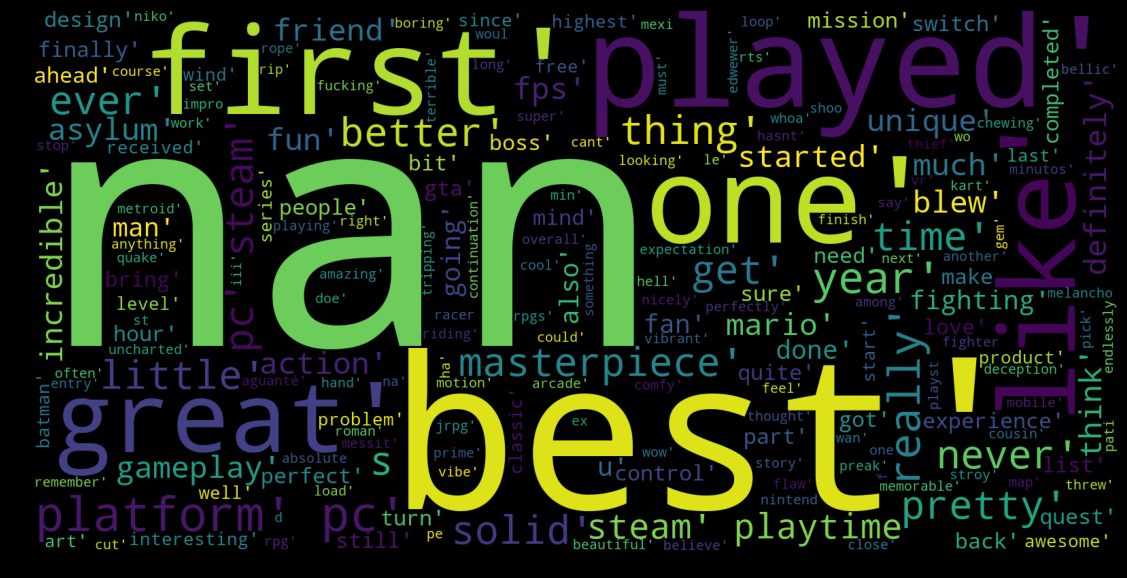

In [ ]:
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud_top200 = WordCloud(background_color = 'black', width=1600,height=800).generate(''.join(str(rawg_reviews_top_200['frequency distributions'])))
plt.figure(figsize = (20,10), facecolor = 'k')
plt.imshow(wordcloud_top200)

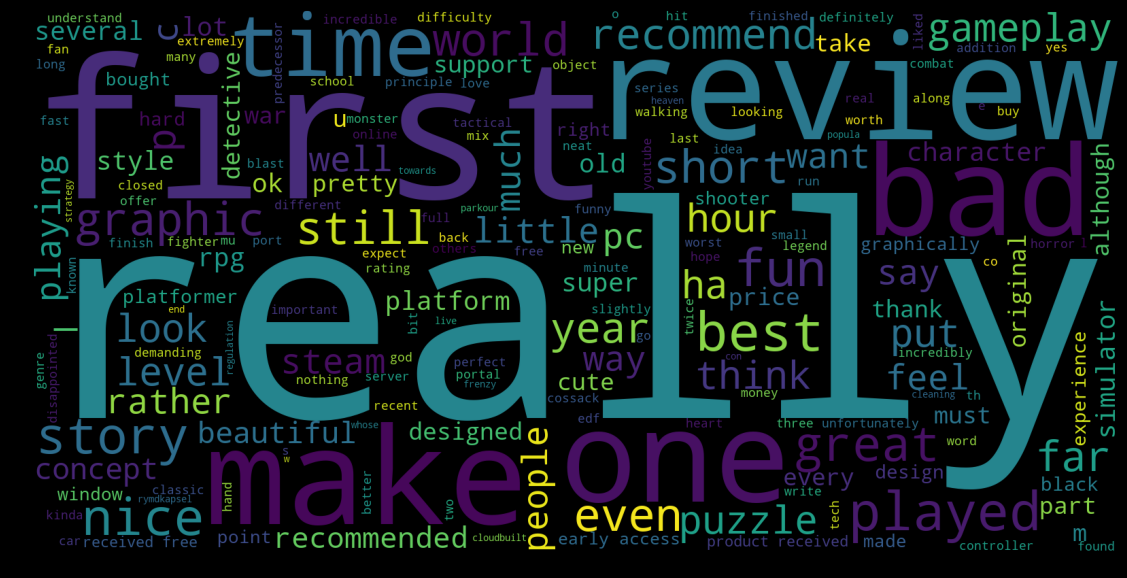

In [ ]:
wordcloud_mid200 = WordCloud(background_color = 'black', width=1600,height=800).generate(''.join(str(rawg_reviews_mid_sample['processed_reviews'])))
plt.figure(figsize = (20,10), facecolor = 'k')
plt.imshow(wordcloud_mid200)

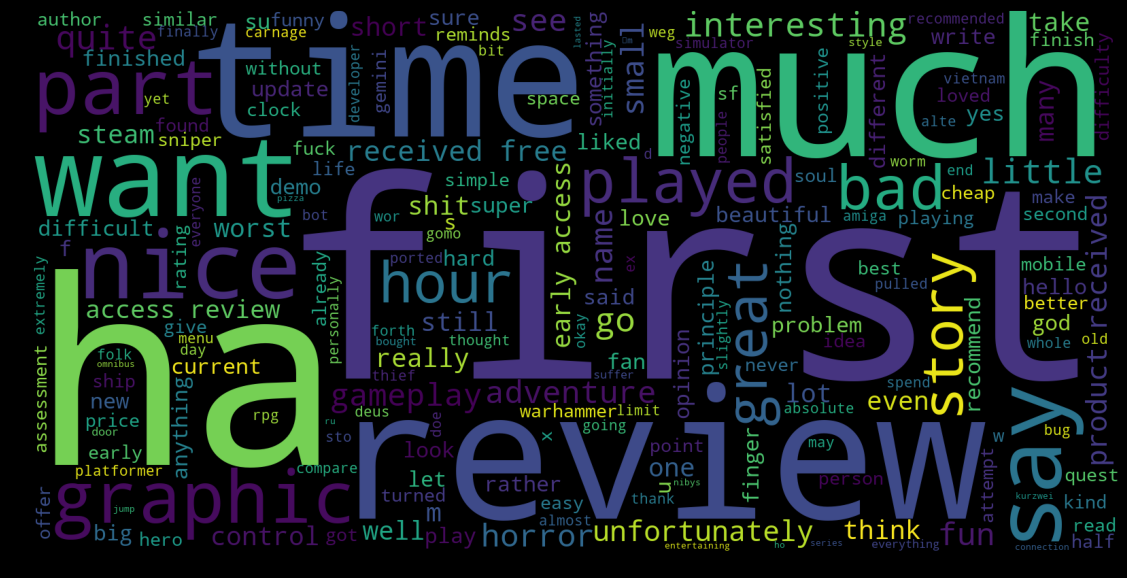

In [ ]:
wordcloud_bottom200 = WordCloud(background_color = 'black', width=1600,height=800).generate(''.join(str(rawg_reviews_bottom_200['processed_reviews'])))
plt.figure(figsize = (20,10), facecolor = 'k')
plt.imshow(wordcloud_bottom200)


In [ ]:
# reassemble game dataframes with their respective nlp features.
rawg_top_200 = pickle.load(open('rawg_top_200_pickle.p', 'rb'))
rawg_bottom_200 = pickle.load(open('rawg_bottom_200_pickle.p', 'rb'))
rawg_mid_sample = pickle.load(open('rawg_middle_200_pickle.p', 'rb'))
for df in [rawg_top_200, rawg_mid_sample, rawg_bottom_200]:
    df.reset_index(inplace = True)
    df.drop('index', axis = 1, inplace = True)

top_reviews = rawg_reviews_top_200[['review_stew', 'avg. review length /words',
       'processed_reviews', 'avg. sentiment score',
       'VADER sentiments Positive', 'VADER sentiments Neutral',
       'VADER sentiments Negative', 'review_lengths',
       'review_lengths_sentiments', 'frequency distributions','frequency_distributions_most_common_10k']]
bottom_reviews =  rawg_reviews_bottom_200[['review_stew', 'avg. review length /words',
       'processed_reviews', 'avg. sentiment score',
       'VADER sentiments Positive', 'VADER sentiments Neutral',
       'VADER sentiments Negative', 'review_lengths',
       'review_lengths_sentiments', 'frequency distributions','frequency_distributions_most_common_10k']]
mid_reviews =  rawg_reviews_mid_sample[['review_stew', 'avg. review length /words',
       'processed_reviews', 'avg. sentiment score',
       'VADER sentiments Positive', 'VADER sentiments Neutral',
       'VADER sentiments Negative', 'review_lengths',
       'review_lengths_sentiments', 'frequency distributions', 'frequency_distributions_most_common_10k']]

rawg_top_200 = pd.concat([rawg_top_200, top_reviews ], axis = 1)
rawg_bottom_200 = pd.concat([rawg_bottom_200,bottom_reviews], axis = 1)
rawg_mid_sample = pd.concat([rawg_mid_sample, mid_reviews], axis =1)



id                                           0
title                                        0
reviews                                      0
review_stew                                  0
avg. review length /words                    0
processed_reviews                            0
processed_reviews_str                      200
avg. sentiment score                         0
VADER sentiments Positive                    0
VADER sentiments Neutral                     0
VADER sentiments Negative                    0
review_lengths                               0
review_lengths_sentiments                    0
frequency distributions                      0
frequency_distributions_most_common_10k      0
frequency_distributions_most_common_5k       0
dtype: int64

# EDA to visualize relationships within the data
As the metacritic score is our guiding feature, we will be looking at other features in relation to  
the metacritic scores by game.  
It is important to determine how well a game's overall metacritic score corresponds to user reviews to   
determine how well metacritic scores (which are based on the reviews of a small selection of professional critics)    
represent the sentiments and or opinions of a large number of actual users.   

C:\Users\Ish\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ish\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ish\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

<function matplotlib.pyplot.show(close=None, block=None)>

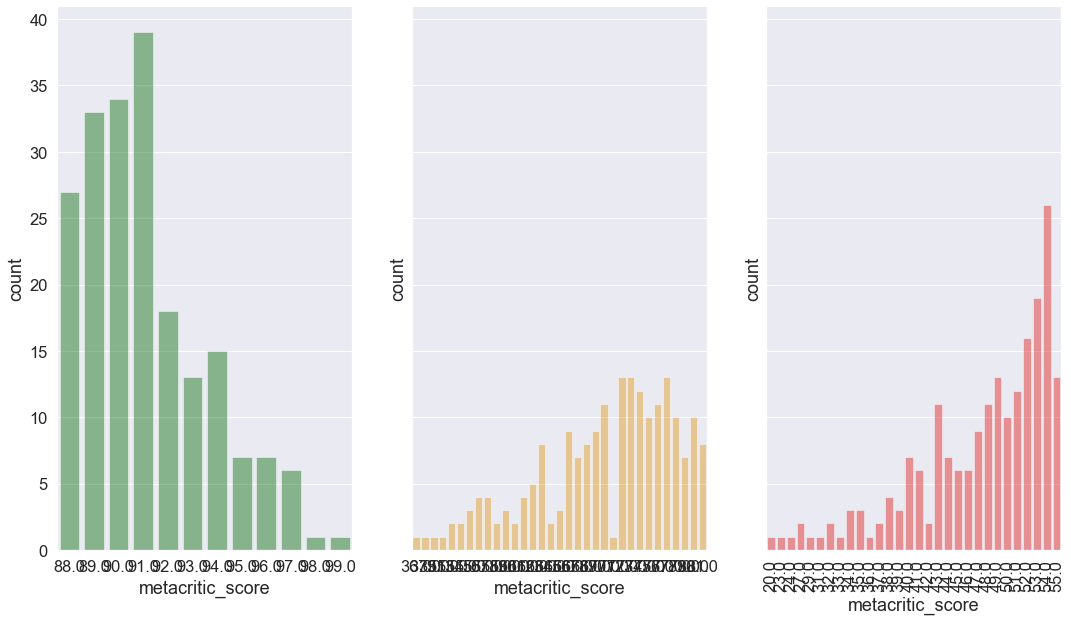

In [ ]:
#Plot the distribution of metacritic scores across the categories of games
sns.set(font_scale = 1.5)
fig, axs = plt.subplots(1,3, figsize = [18,10],sharey = True)
sns.countplot(rawg_top_200['metacritic_score'], ax = axs[0], color = 'green', alpha = 0.45)
sns.countplot(rawg_mid_sample['metacritic_score'], ax= axs[1], color = 'orange', alpha = 0.45)
sns.countplot(rawg_bottom_200['metacritic_score'], ax = axs[2], color = 'red', alpha = 0.45)
plt.xticks(rotation = 90)
plt.show

Text(0.5, 1.0, '(Lower Rated Games)')

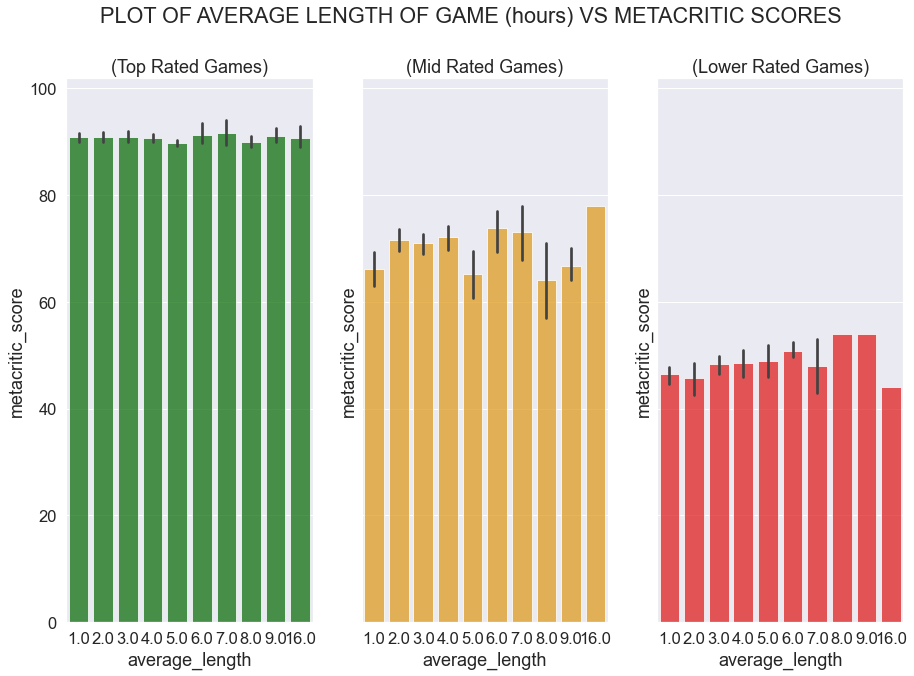

In [ ]:
# plot non-linguistic features against metacritic scores.
sns.set(font_scale = 1.5)
fig, axs = plt.subplots(1,3, figsize = [15,10], sharex = True, sharey = True)
fig.suptitle('PLOT OF AVERAGE LENGTH OF GAME (hours) VS METACRITIC SCORES')

sns.barplot(y= 'metacritic_score', x = 'average_length', data = rawg_top_200, alpha = 0.75, ax = axs[0], color = 'green')
axs[0].set_title('(Top Rated Games)')

sns.barplot(y = 'metacritic_score', x = 'average_length', data = rawg_mid_sample, alpha = 0.75,ax = axs[1], color = 'orange')
axs[1].set_title('(Mid Rated Games)')

sns.barplot(y = 'metacritic_score', x = 'average_length', data = rawg_bottom_200, alpha = 0.75,ax = axs[2], color = 'red')
axs[2].set_title('(Lower Rated Games)')

In [ ]:
import ast
# plot non-linguistic features against metacritic scores.
# convert genre labels to list and select first constituent tags.
genre_vs_metacritic_t200 = rawg_top_200[['metacritic_score', 'genre']]
genre_vs_metacritic_m200 = rawg_mid_sample[['metacritic_score', 'genre']]
genre_vs_metacritic_b200 = rawg_bottom_200[['metacritic_score', 'genre']]
genre_vs_metacritic_total = pd.concat([genre_vs_metacritic_t200, genre_vs_metacritic_m200, genre_vs_metacritic_m200], axis = 0)
genre_vs_metacritic_total.to_excel('genre_vs_metacritic_total.xls')
# define function to convert text representation to list.append
def string_to_list(x):
    try:
        x = eval(x)
        return x[0]
    except:
        pass

#TEST: 
string_to_list(rawg_top_200['genre'][0])
for df in [genre_vs_metacritic_b200, genre_vs_metacritic_m200, genre_vs_metacritic_t200]:
    df['genre'] = df['genre'].apply(lambda x: string_to_list(x))


genre_vs_metacritic_total = pd.concat([genre_vs_metacritic_t200, genre_vs_metacritic_m200, genre_vs_metacritic_m200], axis = 0)
genre_vs_metacritic_total.to_excel('genre_vs_metacritic_total.xls')


C:\Users\Ish\AppData\Local\Temp/ipykernel_43244/3411484768.py:8: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  genre_vs_metacritic_total.to_excel('genre_vs_metacritic_total.xls')
C:\Users\Ish\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\

In [ ]:
genre_vs_metacritic_t200['genre']

0          Action
1          Action
2          Action
3          Action
4          Action
5      Platformer
6      Platformer
7         Shooter
8          Action
9          Action
10       Fighting
11         Action
12         Action
13         Action
14         Action
15         Action
16         Action
17         Action
18         Action
19        Shooter
20         Action
21            RPG
22         Action
23         Action
24         Racing
25            RPG
26      Adventure
27         Action
28         Action
29            RPG
30         Action
31         Action
32            RPG
33         Action
34         Action
35         Action
36         Action
37         Action
38         Action
39         Action
40         Action
41         Action
42       Strategy
43         Action
44         Action
45         Arcade
46      Adventure
47         Racing
48         Action
49            RPG
50            RPG
51      Adventure
52         Action
53         Action
54         Action
55        

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Action'),
  Text(1, 0, 'Platformer'),
  Text(2, 0, 'Shooter'),
  Text(3, 0, 'Fighting'),
  Text(4, 0, 'RPG'),
  Text(5, 0, 'Racing'),
  Text(6, 0, 'Adventure'),
  Text(7, 0, 'Strategy'),
  Text(8, 0, 'Arcade'),
  Text(9, 0, 'Indie'),
  Text(10, 0, 'Simulation')])

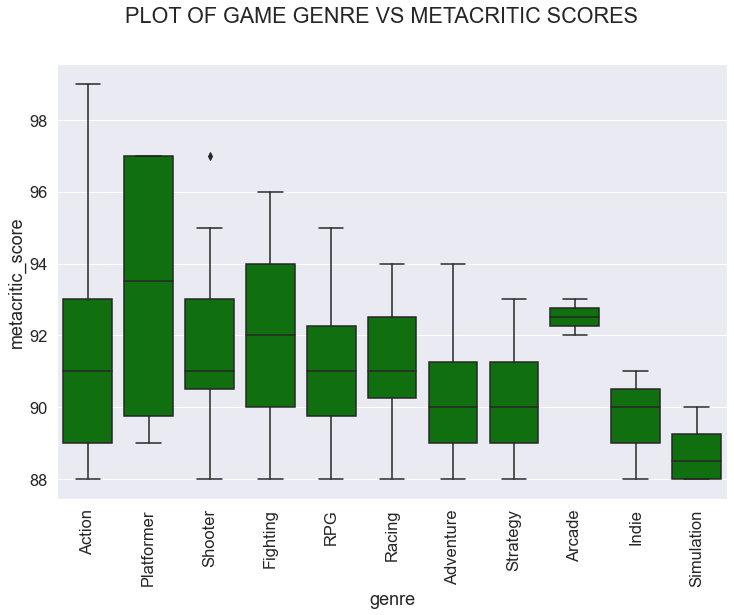

In [ ]:
# plot metacritic scores against genre for top 200 games
sns.set(font_scale = 1.5)
fig = plt.figure(figsize = [12,8])
fig.suptitle('PLOT OF GAME GENRE VS METACRITIC SCORES')

sns.boxplot(y= 'metacritic_score', x = 'genre', data = genre_vs_metacritic_t200, color = 'green')
plt.xticks(rotation = 90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Action'),
  Text(1, 0, 'Adventure'),
  Text(2, 0, 'Strategy'),
  Text(3, 0, 'Indie'),
  Text(4, 0, 'Simulation'),
  Text(5, 0, 'RPG'),
  Text(6, 0, 'Racing'),
  Text(7, 0, 'Sports'),
  Text(8, 0, 'Arcade'),
  Text(9, 0, 'Casual'),
  Text(10, 0, 'Shooter')])

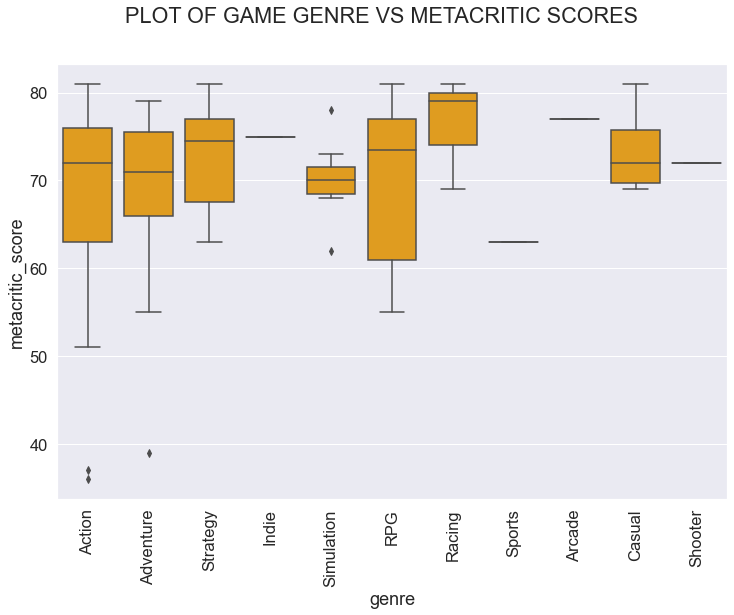

In [ ]:
# plot metacritic scores against genre for middle 200 games
sns.set(font_scale = 1.5)
fig = plt.figure(figsize = [12,8])
fig.suptitle('PLOT OF GAME GENRE VS METACRITIC SCORES')

sns.boxplot(y= 'metacritic_score', x = 'genre', data = genre_vs_metacritic_m200, color = 'orange')
plt.xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Indie'),
  Text(1, 0, 'Strategy'),
  Text(2, 0, 'RPG'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Racing'),
  Text(5, 0, 'Adventure'),
  Text(6, 0, 'Simulation'),
  Text(7, 0, 'Casual'),
  Text(8, 0, 'Sports')])

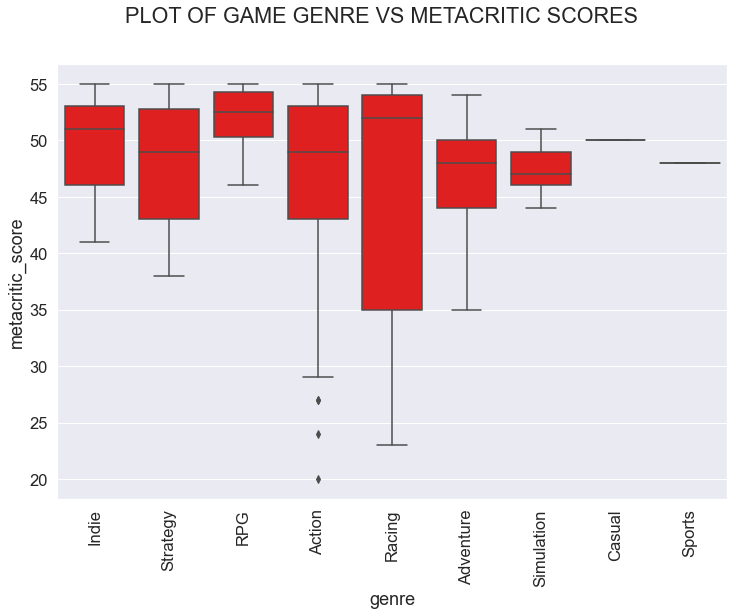

In [ ]:
# plot metacritic scores against genre for bottom 200 games
sns.set(font_scale = 1.5)
fig = plt.figure(figsize = [12,8])
fig.suptitle('PLOT OF GAME GENRE VS METACRITIC SCORES')

sns.boxplot(y= 'metacritic_score', x = 'genre', data = genre_vs_metacritic_b200, color = 'red')
plt.xticks(rotation = 90)

<function matplotlib.pyplot.show(close=None, block=None)>

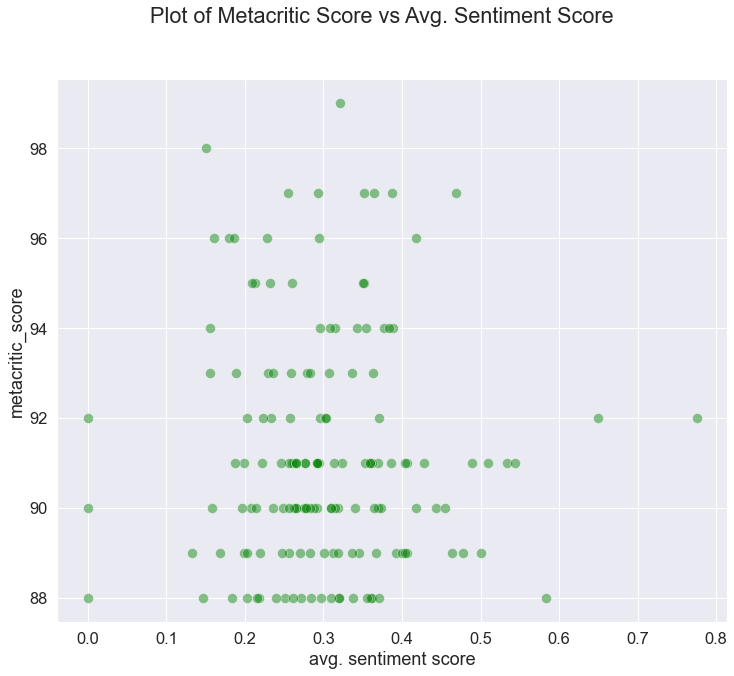

In [ ]:
# plot metacritic scores against average review sentiment scores.
fig, axs = plt.subplots(1, 1, figsize = [12,10], sharex = True, sharey = True)
fig.suptitle('Plot of Metacritic Score vs Avg. Sentiment Score')
# axs[0].plot(0, 0)
# axs[1].plot(0, 1)
# axs[2].plot(0, 2)
sns.scatterplot(y = 'metacritic_score', x = 'avg. sentiment score', data = rawg_top_200, s = 100 , alpha = 0.45, color = 'green')
sns.scatterplot(y = 'metacritic_score', x = 'avg. sentiment score', data = rawg_mid_sample, s = 100, alpha = 0.45, color = 'orange')
sns.scatterplot(y = 'metacritic_score', x = 'avg. sentiment score', data = rawg_bottom_200, s= 100, alpha = 0.45, color = 'red')
plt.show

In [ ]:
rawg_bottom_200['avg. sentiment score']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
24           NaN
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
30           NaN
31           NaN
32           NaN
33           NaN
34           NaN
35           NaN
36           NaN
37           NaN
38           NaN
39           NaN
40           NaN
41           NaN
42           NaN
43           NaN
44           NaN
45           NaN
46           NaN
47           NaN
48           NaN
49           NaN
50           NaN
51           NaN
52           NaN
53           NaN
54           NaN
55           NaN
56           NaN
57           NaN
58           N

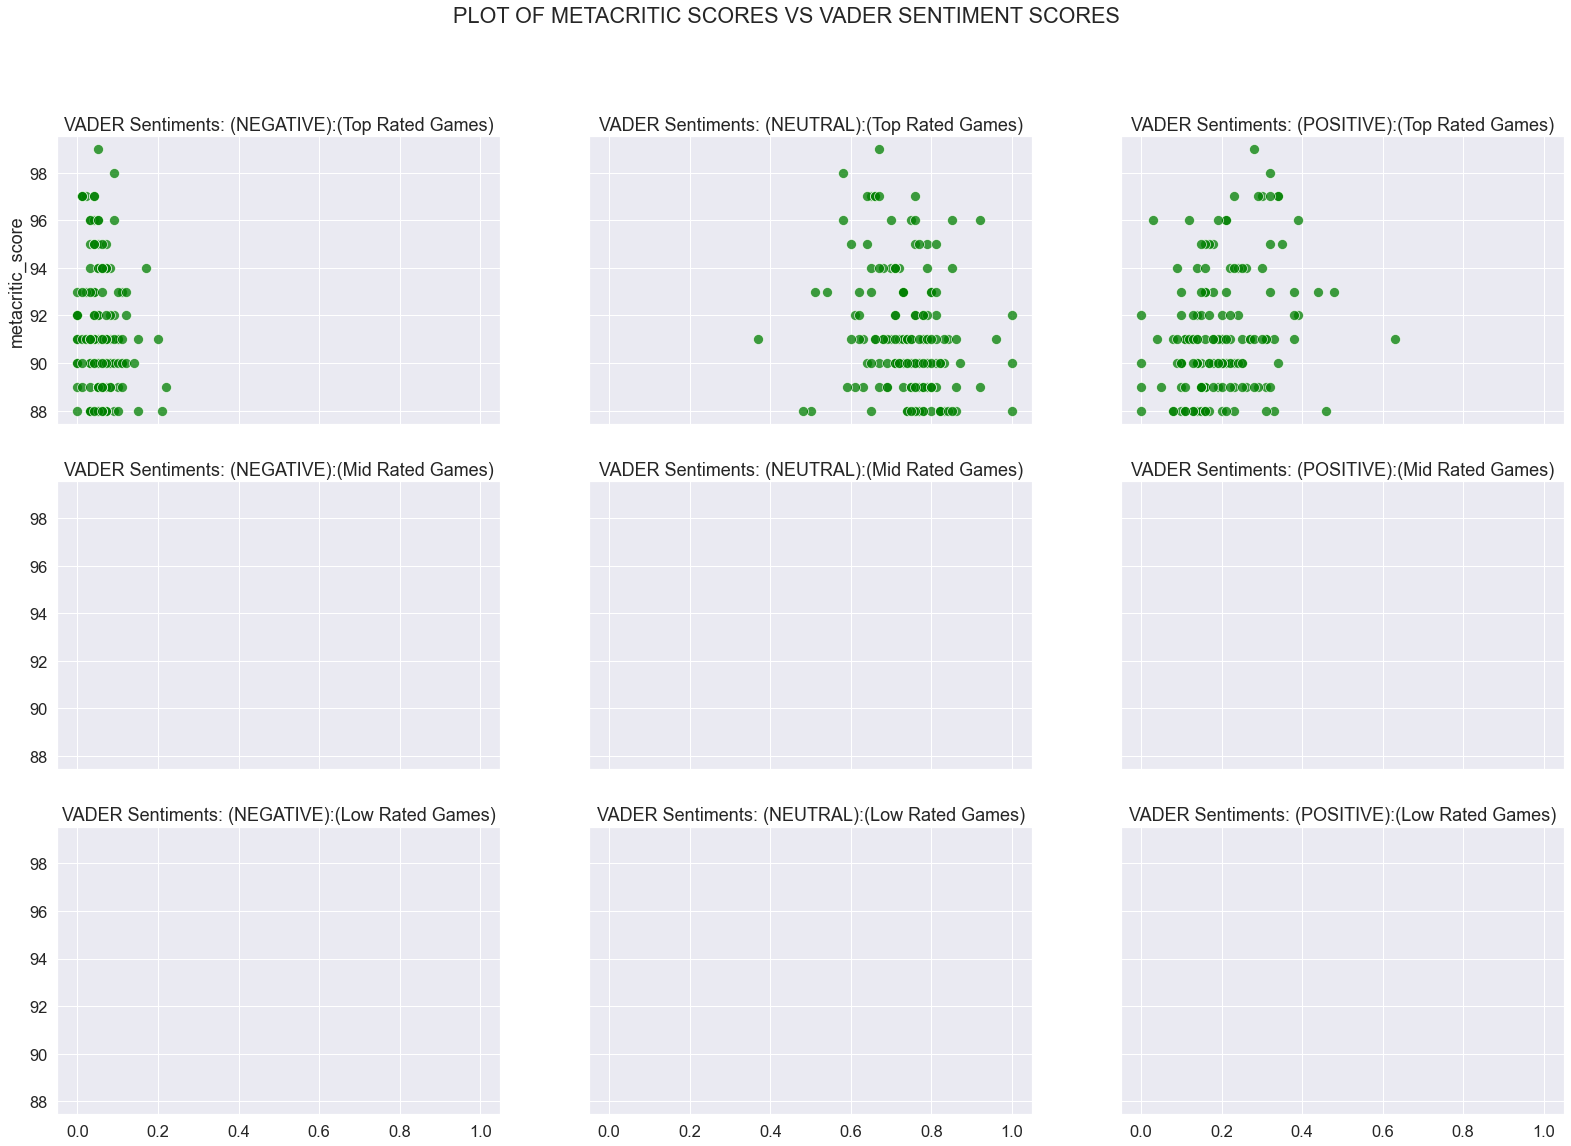

In [ ]:
# plot metacritic scores against VADER sentiment scores.
sns.set(font_scale = 1.5)
fig, axs = plt.subplots(3,3, figsize = [27,18], sharex = True, sharey = True)
fig.suptitle('PLOT OF METACRITIC SCORES VS VADER SENTIMENT SCORES')

sns.scatterplot(y= 'metacritic_score', x = 'VADER sentiments Negative', data = rawg_top_200, alpha = 0.75, s = 100, ax = axs[0,0], color = 'green')
axs[0,0].set_title('VADER Sentiments: (NEGATIVE):(Top Rated Games)')

sns.scatterplot(y = 'metacritic_score', x = 'VADER sentiments Neutral', data = rawg_top_200, alpha = 0.75, s = 100,ax = axs[0,1], color = 'green')
axs[0,1].set_title('VADER Sentiments: (NEUTRAL):(Top Rated Games)')

sns.scatterplot(y = 'metacritic_score', x = 'VADER sentiments Positive', data = rawg_top_200, alpha = 0.75, s = 100,ax = axs[0,2], color = 'green')
axs[0,2].set_title('VADER Sentiments: (POSITIVE):(Top Rated Games)')

sns.scatterplot(y= 'metacritic_score', x = 'VADER sentiments Negative', data = rawg_mid_sample, alpha = 0.75, s = 100,ax = axs[1,0], color = 'orange')
axs[1,0].set_title('VADER Sentiments: (NEGATIVE):(Mid Rated Games)')

sns.scatterplot(y = 'metacritic_score', x = 'VADER sentiments Neutral', data = rawg_mid_sample, alpha = 0.75, s = 100,ax = axs[1,1], color = 'orange')
axs[1,1].set_title('VADER Sentiments: (NEUTRAL):(Mid Rated Games)')

sns.scatterplot(y = 'metacritic_score', x = 'VADER sentiments Positive', data = rawg_mid_sample, alpha = 0.75, s = 100,ax = axs[1,2], color = 'orange')
axs[1,2].set_title('VADER Sentiments: (POSITIVE):(Mid Rated Games)')

sns.scatterplot(y= 'metacritic_score', x = 'VADER sentiments Negative', data = rawg_bottom_200, alpha = 0.75, s = 100,ax = axs[2,0], color = 'red')
axs[2,0].set_title('VADER Sentiments: (NEGATIVE):(Low Rated Games)')

sns.scatterplot(y = 'metacritic_score', x = 'VADER sentiments Neutral', data = rawg_bottom_200, alpha = 0.75, s = 100,ax = axs[2,1], color = 'red')
axs[2,1].set_title('VADER Sentiments: (NEUTRAL):(Low Rated Games)' )

sns.scatterplot(y = 'metacritic_score', x = 'VADER sentiments Positive', data = rawg_bottom_200, alpha = 0.75, s = 100,ax = axs[2,2], color = 'red')
axs[2,2].set_title('VADER Sentiments: (POSITIVE):(Low Rated Games)')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

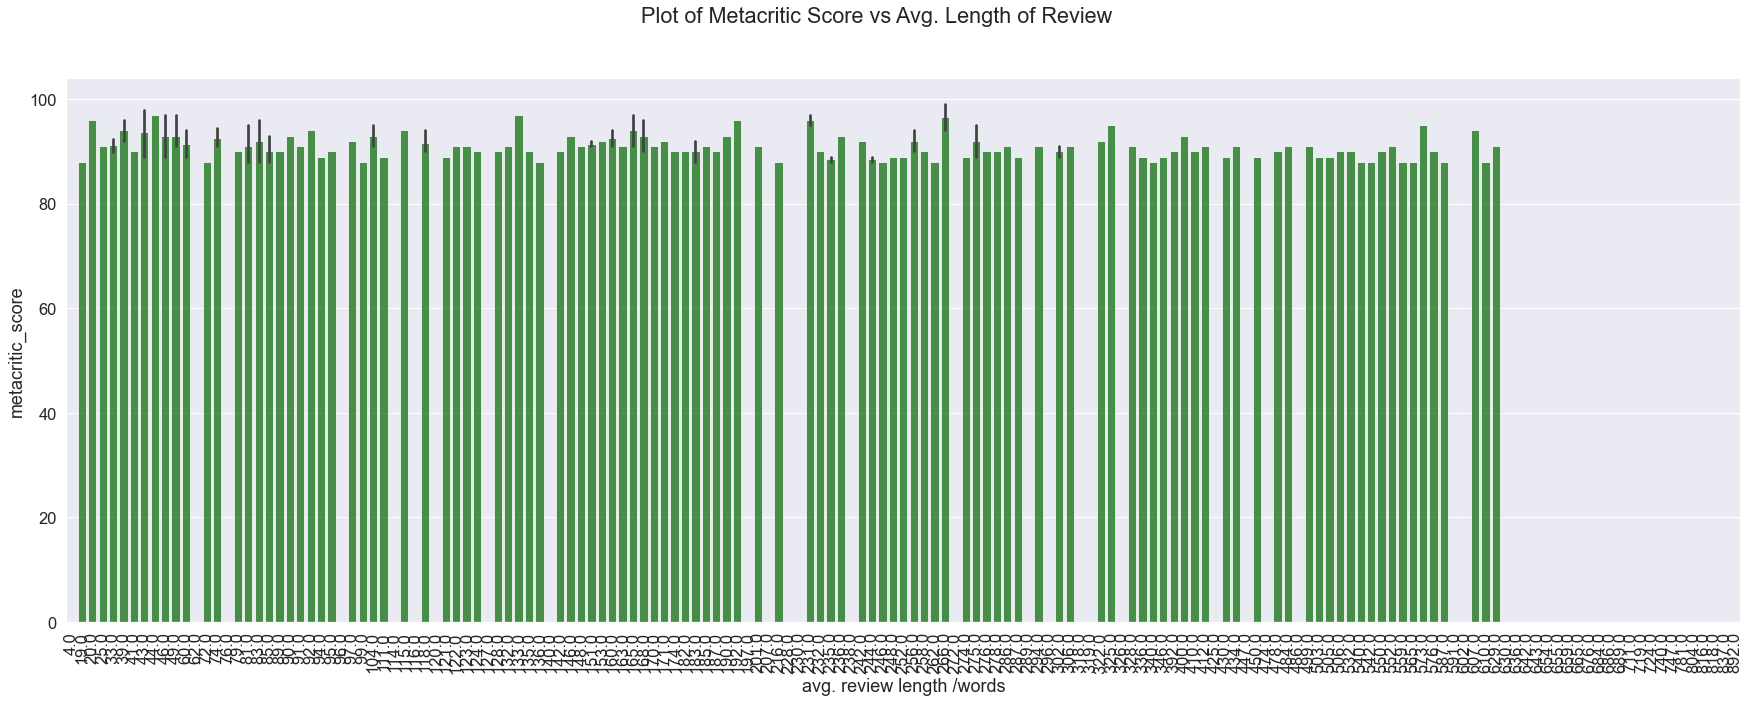

In [ ]:
# plot metacritic scores against average review lengths.
# one assumption is that the stronger a person feels about the topic the more likely they will be to write longer reviews.
fig, axs = plt.subplots(1, 1, figsize = [30,10], sharex = True, sharey = True)
fig.suptitle('Plot of Metacritic Score vs Avg. Length of Review')
sns.barplot(y = 'metacritic_score', x = 'avg. review length /words', data = rawg_top_200, alpha = 0.75, color = 'green')
sns.barplot(y = 'metacritic_score', x = 'avg. review length /words', data = rawg_mid_sample, alpha = 0.75, color = 'orange')
sns.barplot(y = 'metacritic_score', x = 'avg. review length /words', data = rawg_bottom_200, alpha = 0.95, color = 'red')
plt.xticks(rotation = 90)

plt.show

# Decompose Length of Review and Sentiment data for plotting
Owing to how the review length and sentiment data was stored earlier  
it needs to be broken down and stored as new dataframe for plotting.

In [ ]:
#Create a dataframe of the review lengths to sentiments

def len2sent_frame(pd_df):
    sentiment_lengths = pd_df[['metacritic_score','review_lengths_sentiments']]
    lengths_to_sentiments = pd.DataFrame.from_dict(sentiment_lengths['review_lengths_sentiments'])

    keys = []   
    for x in lengths_to_sentiments['review_lengths_sentiments']:
        keys.append(x.keys())
    values = []
    for key in keys:
        for k in key:
            for x in lengths_to_sentiments['review_lengths_sentiments']:
                try:
                    values.append(x[k])
                except:
                    pass
    length = []
    vader_scores = []
    for x in values:
        length.append(x[1])
        vader_scores.append(x[2])

    lengths_to_values = dict(zip(length, vader_scores))
    lengths_to_values

    len_to_sents = pd.DataFrame.from_dict(lengths_to_values).transpose().reset_index()
    len_to_sents.columns =  ['Review length /words', 'VADER sentiments Negative','VADER sentiments Neutral','VADER sentiments Positive']
    return len_to_sents

len_sent_top_200 = len2sent_frame(rawg_top_200)
#len_sent_top_200

len_sent_mid_200 = len2sent_frame(rawg_mid_sample)
#len_sent_mid_200

len_sent_bottom_200 = len2sent_frame(rawg_bottom_200)
#len_sent_bottom_200

review_length_to_sentiment = pd.concat([len_sent_top_200, len_sent_mid_200, len_sent_bottom_200], axis = 0)
review_length_to_sentiment.to_excel('review_length_to_sentiment.xls')

AttributeError: 'float' object has no attribute 'keys'

In [ ]:
# Plot the lengths of reviews against the respective VADER Sentiment scores for each group of reviews.
sns.set(font_scale = 1.5)
fig, axs = plt.subplots(3,3, figsize = [33,21], sharex = True, sharey = True)
fig.suptitle('PLOT OF REVIEW LENGTH VS VADER SENTIMENT SCORES')

sns.scatterplot(y= 'Review length /words', x = 'VADER sentiments Negative', data = len_sent_top_200, alpha = 0.75, ax = axs[0,0], color = 'green')
axs[0,0].set_title('VADER Sentiments: (NEGATIVE) vs Review length /words (Top Rated Games)')

sns.scatterplot(y = 'Review length /words', x = 'VADER sentiments Neutral', data = len_sent_top_200, alpha = 0.75,ax = axs[0,1], color = 'green')
axs[0,1].set_title('VADER Sentiments: (NEUTRAL) vs Review length /words (Top Rated Games)')

sns.scatterplot(y = 'Review length /words', x = 'VADER sentiments Positive', data = len_sent_top_200, alpha = 0.75,ax = axs[0,2], color = 'green')
axs[0,2].set_title('VADER Sentiments: (POSITIVE) vs Review length /words (Top Rated Games)')

sns.scatterplot(y= 'Review length /words', x = 'VADER sentiments Negative', data = len_sent_mid_200, alpha = 0.75,ax = axs[1,0], color = 'orange')
axs[1,0].set_title('VADER Sentiments: (NEGATIVE) vs Review length /words (Mid Rated Games)')

sns.scatterplot(y = 'Review length /words', x = 'VADER sentiments Neutral', data = len_sent_mid_200, alpha = 0.75,ax = axs[1,1], color = 'orange')
axs[1,1].set_title('VADER Sentiments: (NEUTRAL) vs Review length /words (Mid Rated Games)')

sns.scatterplot(y = 'Review length /words', x = 'VADER sentiments Positive', data = len_sent_mid_200, alpha = 0.75,ax = axs[1,2], color = 'orange')
axs[1,2].set_title('VADER Sentiments: (POSITIVE) vs Review length /words (Mid Rated Games)')

sns.scatterplot(y= 'Review length /words', x = 'VADER sentiments Negative', data = len_sent_bottom_200, alpha = 0.75,ax = axs[2,0], color = 'red')
axs[2,0].set_title('VADER Sentiments: (NEGATIVE) vs Review length /words (Low Rated Games)')

sns.scatterplot(y = 'Review length /words', x = 'VADER sentiments Neutral', data = len_sent_bottom_200, alpha = 0.75,ax = axs[2,1], color = 'red')
axs[2,1].set_title('VADER Sentiments: (NEUTRAL) vs Review length /words (Low Rated Games)' )

sns.scatterplot(y = 'Review length /words', x = 'VADER sentiments Positive', data = len_sent_bottom_200, alpha = 0.75,ax = axs[2,2], color = 'red')
axs[2,2].set_title('VADER Sentiments: (POSITIVE) vs Review length /words (Low Rated Games)')

plt.show()